# Imports

In [47]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torchvision.datasets import MNIST
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# from Neural_Networks import epochs, training_accurices, validation_accurices

# 1. Data preparation

### 1.1. Read data from file

In [48]:
#load the datasets (train data and test data which are pre-splitted)
data1 = MNIST(root='MNIST_dataset', train=True, download=True)
data2 = MNIST(root='MNIST_dataset', train=False, download=True)

#concatenate the data and labels from train and test datasets
all_images = torch.cat((data1.data, data2.data), dim=0)
all_labels = torch.cat((data1.targets, data2.targets), dim=0)

Now, we have 70,000 images intotal.

In [49]:
x = all_images.numpy()
y = all_labels.numpy()

print("Total images:", x.shape[0])

Total images: 70000


### 1.2. Normalizing the data

In [50]:
x = x / 255.0  # Normalize pixel values to [0, 1] range

print("min pixel value:", x.min(), ", max pixel value:", x.max())

min pixel value: 0.0 , max pixel value: 1.0


### 1.3. Splitting into train, validtaion and test sets

In [51]:
x_train, x_rest, y_train, y_rest = train_test_split(x, y, train_size= 0.6, random_state=42, stratify=y) # 60% train, 40% to split again into val and test
x_val, x_test, y_val, y_test = train_test_split(x_rest, y_rest, train_size=0.5, random_state=42, stratify=y_rest) # 40% * 50% = 20% val, 20% test

print("Training set = ", x_train.shape[0])
print("Validation set = ", x_val.shape[0])
print("Test set = ", x_test.shape[0])

Training set =  42000
Validation set =  14000
Test set =  14000


In [52]:
x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_val_flat = x_val.reshape(x_val.shape[0], -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)

# Verify the new shape
print(f"Original shape: {x_train.shape}")
print(f"Flattened shape: {x_train_flat.shape}")

Original shape: (42000, 28, 28)
Flattened shape: (42000, 784)


### 1.4. Pytorch DataLoaders

In [53]:
# Change from numpy arrays to tensors
x_train_tensor = torch.from_numpy(x_train_flat).unsqueeze(1).float()
y_train_tensor = torch.from_numpy(y_train).long()

x_val_tensor = torch.from_numpy(x_val_flat).unsqueeze(1).float()
y_val_tensor = torch.from_numpy(y_val).long()

x_test_tensor = torch.from_numpy(x_test_flat).unsqueeze(1).float()
y_test_tensor = torch.from_numpy(y_test).long()

train_dataset = torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = torch.utils.data.TensorDataset(x_val_tensor, y_val_tensor)
test_dataset = torch.utils.data.TensorDataset(x_test_tensor, y_test_tensor)

# Create DataLoaders with batch size = 64 to optimize training
train_NN_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_NN_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_NN_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 2. Linear Classification Models

## 2.1. Logistic Regression

For logistic regression, it's a binary classifier, so we need to use two digits only as classes.

### 2.1.1. Data preparation For Binary Classification

Boolean masking is used to filter the dataset for two specific digits.

In [54]:
def filter_digits(x, y, digit1, digit2):
    filter_mask = (y == digit1) | (y == digit2)

    x_filtered = x[filter_mask]
    y_filtered = y[filter_mask]

    y_filtered = np.where(y_filtered == digit1, 0, 1) # Map digit1 to 0 and digit2 to 1
    return x_filtered, y_filtered

Filter the data for only 2 digits.

In [55]:
DIGIT_A = 0
DIGIT_B = 1

x_binary_train_flat, y_binary_train = filter_digits(x_train_flat, y_train, DIGIT_A, DIGIT_B)
x_binary_val_flat, y_binary_val = filter_digits(x_val_flat, y_val, DIGIT_A, DIGIT_B)
x_binary_test_flat, y_binary_test = filter_digits(x_test_flat, y_test, DIGIT_A, DIGIT_B)

In [56]:
print(x_binary_train_flat.shape, y_binary_train.shape)
print(x_binary_val_flat.shape, y_binary_val.shape)
print(x_binary_test_flat.shape, y_binary_test.shape)

(8868, 784) (8868,)
(2957, 784) (2957,)
(2955, 784) (2955,)


In [57]:
# Convert to float tensors
# Convert labels to columns vector
x_train_binary_tensor = torch.from_numpy(x_binary_train_flat).float()
y_train_binary_tensor = torch.from_numpy(y_binary_train).float().view(-1, 1)

x_val_binary_tensor = torch.from_numpy(x_binary_val_flat).float()
y_val_binary_tensor = torch.from_numpy(y_binary_val).float().view(-1, 1)

x_test_binary_tensor = torch.from_numpy(x_binary_test_flat).float()
y_test_binary_tensor = torch.from_numpy(y_binary_test).float().view(-1, 1)

train_binary_dataset = torch.utils.data.TensorDataset(x_train_binary_tensor, y_train_binary_tensor)
val_binary_dataset = torch.utils.data.TensorDataset(x_val_binary_tensor, y_val_binary_tensor)
test_binary_dataset = torch.utils.data.TensorDataset(x_test_binary_tensor, y_test_binary_tensor)

train_lr_loader = DataLoader(train_binary_dataset, batch_size=64, shuffle=True)
val_lr_loader = DataLoader(val_binary_dataset, batch_size=64, shuffle=False)
test_lr_loader = DataLoader(test_binary_dataset, batch_size=64, shuffle=False)

### 2.1.2. Defining The Model

In [58]:
INPUT_FEATURES = 784 # Number of pixels/inputs (28x28)
OUTPUT_FEATURES = 1  # The output is either 0 or 1

# Create the weights tensor of random numbers with size of (784, 1)
weights = torch.randn(INPUT_FEATURES, OUTPUT_FEATURES, dtype=torch.float)

# Create the bias tensor of zeros with size of 1 element
bias = torch.zeros(OUTPUT_FEATURES, dtype=torch.float)

# Enable gradient tracking for weights and bias
weights.requires_grad = True
bias.requires_grad = True

Define Sigmoid activation function and the binary cross entropy loss function.

In [59]:
def sigmoid(z):
    return 1.0 / (1.0 + torch.exp(-z))

# y_true are the labels (0 or 1) and y_pred_logits are the model outputs (logits)
def binary_cross_entropy_loss(y_true, y_pred_logits):

    p = sigmoid(y_pred_logits)
    
    # Prevent log(0) by adding a small value (epsilon)
    epsilon = 1e-7

    loss_per_item = - ( y_true * torch.log(p + epsilon) + (1.0 - y_true) * torch.log(1.0 - p + epsilon) )

    # Return average
    return torch.mean(loss_per_item)

### 2.1.3 Training The Model

In [60]:
learning_rate = 0.01
num_epochs = 100

train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

for epoch in range(num_epochs):
    correct, total, epoch_loss = 0,0,0

    for x_batch, y_batch in train_lr_loader:
        # Forward Pass
        logits = x_batch @ weights + bias

        loss = binary_cross_entropy_loss(y_batch, logits)
        loss.backward()

        with torch.no_grad():
            weights -= learning_rate * weights.grad
            bias -= learning_rate * bias.grad

        # Reset Gradients
        weights.grad.zero_()
        bias.grad.zero_()

        # Track Loss
        epoch_loss += loss.item() * x_batch.size(0)

        # Compute Accuracy
        predictions = (sigmoid(logits) >= 0.5).float()
        correct += (predictions == y_batch).sum().item()
        total += x_batch.size(0)

    train_losses.append(epoch_loss / total)
    train_accuracies.append(correct / total)

    # Validation
    with torch.no_grad():
        val_logits = x_val_binary_tensor @ weights + bias
        val_predictions = sigmoid(val_logits)
        val_loss = binary_cross_entropy_loss(y_val_binary_tensor, val_logits)
        val_losses.append(val_loss.item())

        val_pred_labels = (val_predictions >= 0.5).float()
        val_accuracy = (val_pred_labels == y_val_binary_tensor).float().mean().item()
        val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_accuracies[-1]*100:.2f}% | "
          f"Val Acc: {val_accuracies[-1]*100:.2f}%")

Epoch 1/100 | Train Loss: 0.6260 | Train Acc: 81.20% | Val Acc: 88.47%
Epoch 2/100 | Train Loss: 0.2773 | Train Acc: 90.91% | Val Acc: 93.24%
Epoch 3/100 | Train Loss: 0.1768 | Train Acc: 94.28% | Val Acc: 95.37%
Epoch 4/100 | Train Loss: 0.1323 | Train Acc: 95.90% | Val Acc: 96.42%
Epoch 5/100 | Train Loss: 0.1074 | Train Acc: 96.71% | Val Acc: 96.96%
Epoch 6/100 | Train Loss: 0.0917 | Train Acc: 97.25% | Val Acc: 97.40%
Epoch 7/100 | Train Loss: 0.0807 | Train Acc: 97.61% | Val Acc: 97.70%
Epoch 8/100 | Train Loss: 0.0726 | Train Acc: 97.87% | Val Acc: 98.04%
Epoch 9/100 | Train Loss: 0.0664 | Train Acc: 98.08% | Val Acc: 98.24%
Epoch 10/100 | Train Loss: 0.0615 | Train Acc: 98.38% | Val Acc: 98.44%
Epoch 11/100 | Train Loss: 0.0575 | Train Acc: 98.48% | Val Acc: 98.48%
Epoch 12/100 | Train Loss: 0.0542 | Train Acc: 98.61% | Val Acc: 98.61%
Epoch 13/100 | Train Loss: 0.0513 | Train Acc: 98.67% | Val Acc: 98.82%
Epoch 14/100 | Train Loss: 0.0489 | Train Acc: 98.67% | Val Acc: 98.92%
E

### 2.1.4 Loss & Accuracy Curves for Training and Validation


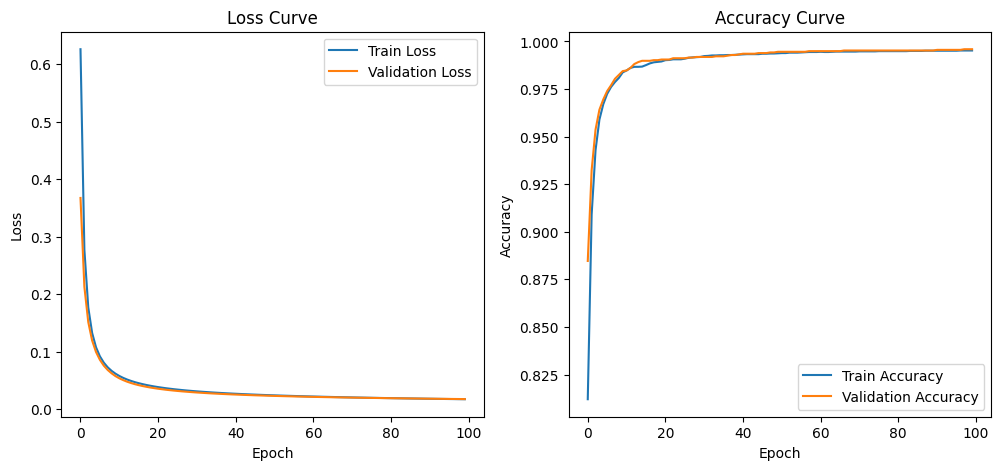

In [61]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

### 2.1.5 Test Accuracy & Confusion Matrix


Test Accuracy: 99.29%


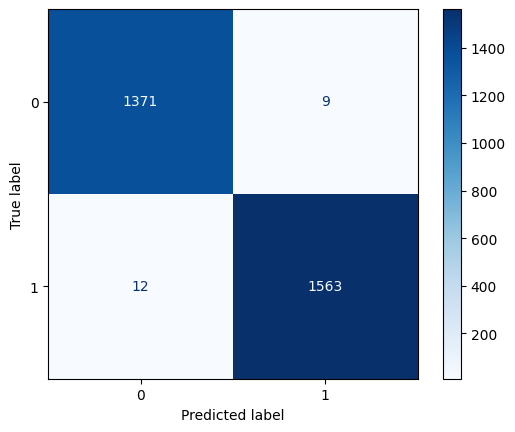

In [62]:
with torch.no_grad():
    test_logits = x_test_binary_tensor @ weights + bias
    test_predictions = (sigmoid(test_logits) >= 0.5).float()

test_accuracy = (test_predictions == y_test_binary_tensor).float().mean().item()
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

cm = confusion_matrix(y_test_binary_tensor.numpy(), test_predictions.numpy())
ConfusionMatrixDisplay(cm, display_labels=[DIGIT_A, DIGIT_B]).plot(cmap="Blues")
plt.show()

## 2.2. SoftMax Regression

### 2.2.1. Data preparation For Multi-class Classification

Already done in the previous section


### 2.2.2 Defining the Model

In [63]:
INPUT_FEATURES = 784 # Number of pixels/inputs (28x28)
NUM_CLASSES = 10 # The output may differ from 0 to 9

# Create the weights tensor of random numbers with size of (784, 10)
weights_soft = torch.randn(INPUT_FEATURES, NUM_CLASSES, dtype=torch.float)

# Create the bias tensor of zeros with size of 10 elements
bias_soft = torch.zeros(NUM_CLASSES, dtype=torch.float)

# Enable gradient tracking for weights and bias
weights_soft.requires_grad = True
bias_soft.requires_grad = True

Define Softmax Function & Cross Entropy Loss

In [64]:
def softmax(logits):
    exp_scores = torch.exp(logits)
    return exp_scores / torch.sum(exp_scores, dim=1, keepdim=True)

def softmax_cross_entropy_loss(y_true, logits):
    # Apply softmax to get probabilities
    probs = softmax(logits)

    # eps to avoid log(0)
    epsilon = 1e-7
    correct_log_probs = -torch.log(probs[range(len(y_true)), y_true] + epsilon)

    return torch.mean(correct_log_probs), probs

### 2.2.3. Training The Model

In [65]:
learning_rate = 0.01
num_epochs = 100

train_soft_losses, val_soft_losses, train_soft_accuracies, val_soft_accuracies = [], [], [], []

for epoch in range(num_epochs):
    correct, total, epoch_loss = 0,0,0

    for x_batch, y_batch in train_NN_loader:
        # Forward Pass
        x_batch = x_batch.squeeze(1)
        y_batch = y_batch.long().view(-1)
        logits = x_batch @ weights_soft + bias_soft

        loss, probs = softmax_cross_entropy_loss(y_batch, logits)
        loss.backward()

        with torch.no_grad():
            weights_soft -= learning_rate * weights_soft.grad
            bias_soft -= learning_rate * bias_soft.grad

        # Reset Gradients
        weights_soft.grad.zero_()
        bias_soft.grad.zero_()

        # Track Loss
        epoch_loss += loss.item() * x_batch.size(0)

        # Compute Accuracy
        correct += (probs.argmax(dim=1) == y_batch).sum().item()
        total += x_batch.size(0)

    train_soft_losses.append(epoch_loss / total)
    train_soft_accuracies.append(correct / total)

    # Validation
    with torch.no_grad():
        val_logits = x_val_tensor.squeeze(1) @ weights_soft + bias_soft
        y_val_indices = y_val_tensor.long().view(-1)
        val_loss, val_probs = softmax_cross_entropy_loss(y_val_indices, val_logits)

        val_soft_losses.append(val_loss.item())
        val_soft_accuracies.append((val_probs.argmax(1) == y_val_indices).float().mean().item())

    print(f"Epoch {epoch+1}/{num_epochs} | Train Acc: {train_soft_accuracies[-1]*100:.2f}% | Val Acc: {val_soft_accuracies[-1]*100:.2f}%")


Epoch 1/100 | Train Acc: 22.68% | Val Acc: 32.48%
Epoch 2/100 | Train Acc: 39.12% | Val Acc: 44.99%
Epoch 3/100 | Train Acc: 49.16% | Val Acc: 53.16%
Epoch 4/100 | Train Acc: 56.74% | Val Acc: 60.40%
Epoch 5/100 | Train Acc: 62.39% | Val Acc: 65.07%
Epoch 6/100 | Train Acc: 66.51% | Val Acc: 68.69%
Epoch 7/100 | Train Acc: 69.54% | Val Acc: 70.94%
Epoch 8/100 | Train Acc: 71.72% | Val Acc: 72.84%
Epoch 9/100 | Train Acc: 73.55% | Val Acc: 74.25%
Epoch 10/100 | Train Acc: 75.10% | Val Acc: 75.28%
Epoch 11/100 | Train Acc: 76.21% | Val Acc: 76.26%
Epoch 12/100 | Train Acc: 77.24% | Val Acc: 77.24%
Epoch 13/100 | Train Acc: 78.05% | Val Acc: 77.94%
Epoch 14/100 | Train Acc: 78.73% | Val Acc: 78.61%
Epoch 15/100 | Train Acc: 79.33% | Val Acc: 79.09%
Epoch 16/100 | Train Acc: 79.89% | Val Acc: 79.59%
Epoch 17/100 | Train Acc: 80.39% | Val Acc: 80.06%
Epoch 18/100 | Train Acc: 80.84% | Val Acc: 80.59%
Epoch 19/100 | Train Acc: 81.22% | Val Acc: 81.00%
Epoch 20/100 | Train Acc: 81.64% | Val A

### 2.2.4. Loss & Accuracy Curves for Training and Validation


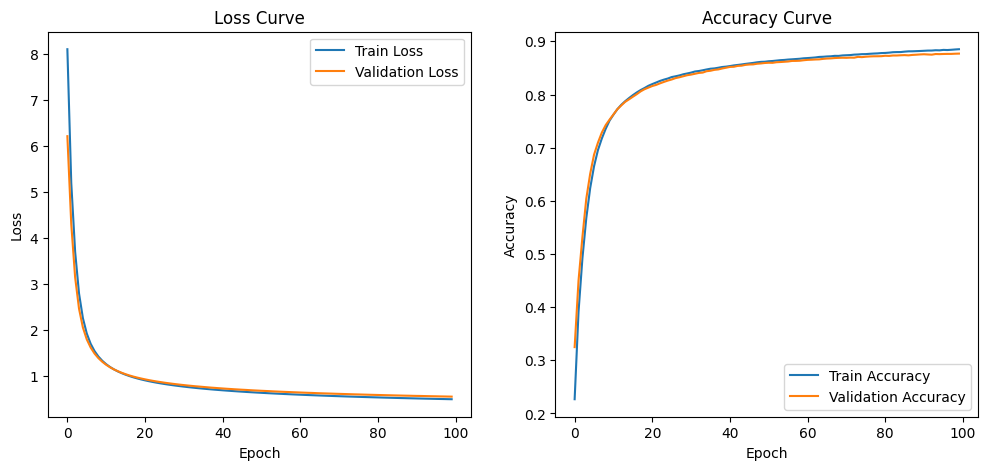

In [66]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_soft_losses, label="Train Loss")
plt.plot(val_soft_losses, label="Validation Loss")
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_soft_accuracies, label="Train Accuracy")
plt.plot(val_soft_accuracies, label="Validation Accuracy")
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

### 2.1.5 Test Accuracy & Confusion Matrix

Test Accuracy: 87.75%

Per-Class Accuracy:
Digit 0: 94.28%
Digit 1: 95.68%
Digit 2: 86.77%
Digit 3: 84.32%
Digit 4: 88.94%
Digit 5: 78.46%
Digit 6: 94.11%
Digit 7: 88.83%
Digit 8: 80.81%
Digit 9: 83.47%


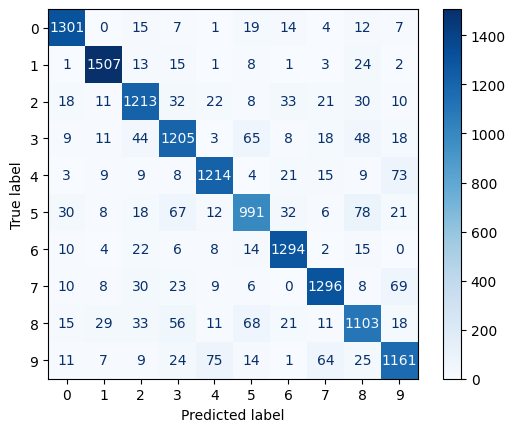

In [83]:
with torch.no_grad():
    x_test_flat = x_test_tensor.squeeze(1)      # shape [N,784]
    y_test_idx = y_test_tensor.long().view(-1)  # shape [N]
    # Forward Pass (logits)
    test_logits = x_test_flat @ weights_soft + bias_soft # shape [N, 10]
    # Numerical-stable softmax
    test_probs = softmax(test_logits)    # Predicted class = index of max probability
    test_pred_labels = test_probs.argmax(dim=1)

# Compute Accuracy
test_accuracy = (test_pred_labels == y_test_idx).float().mean().item()
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

# Per-Class Accuracy Analysis
print("\nPer-Class Accuracy:")
for digit in range(10):
    mask = (y_test_idx == digit)
    correct = (test_pred_labels[mask] == digit).sum().item()
    total = mask.sum().item()
    acc = correct / total if total > 0 else 0
    print(f"Digit {digit}: {acc*100:.2f}%")

# Confusion Matrix
cm = confusion_matrix(y_test_idx.numpy(), test_pred_labels.numpy(), labels=list(range(10)))
ConfusionMatrixDisplay(cm, display_labels=list(range(10))).plot(cmap="Blues")
plt.show()

### 2.1.6. PyTorch Built-In Model Comparison

In [88]:
# PyTorch Softmax Regression Model (Linear Layer Only)
model = nn.Linear(INPUT_FEATURES, NUM_CLASSES)
# Loss and Optimizer, same settings as manual model
optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# Train the PyTorch built-in model
for epoch in range(5): # 5 epochs is enough for comparison
    correct, total = 0, 0
    for x_batch, y_batch in train_NN_loader:
        x_batch = x_batch.squeeze(1)
        y_batch = y_batch.long()

        logits = model(x_batch)
        loss = criterion(logits, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Compute accuracy
        correct += (logits.argmax(dim=1) == y_batch).sum().item()
        total += x_batch.size(0)

    print(f"Built-in Model Epoch {epoch+1} | Train Accuracy: {correct/total*100:.2f}%")


# Evaluate built-in model
with torch.no_grad():
    x_test_flat = x_test_tensor.squeeze(1)
    logits = model(x_test_flat)
    preds = logits.argmax(dim=1)

baseline_acc = (preds == y_test_tensor).float().mean().item()
print(f"PyTorch Built-In Softmax Test Accuracy: {baseline_acc*100:.2f}%")
print(f"Manual Implementation Test Accuracy: {test_accuracy*100:.2f}%")


Built-in Model Epoch 1 | Train Accuracy: 78.29%
Built-in Model Epoch 2 | Train Accuracy: 86.08%
Built-in Model Epoch 3 | Train Accuracy: 87.44%
Built-in Model Epoch 4 | Train Accuracy: 88.17%
Built-in Model Epoch 5 | Train Accuracy: 88.72%
PyTorch Built-In Softmax Test Accuracy: 88.61%
Manual Implementation Test Accuracy: 87.75%
